In [1]:
import numpy as np
import tensorflow as tf

from Util.arc_cosine_kernel import Arc_Cosine_Kernel
from Util.random_relu_network import Single_Layer_Relu_Network
from Util.random_relu_network import Random_Relu_Network

import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise
from sklearn.linear_model import SGDClassifier

# Random Feature VS Exact Arc Cosine Kernel

In [2]:
n_samples = 5000

width_list = [10, 100, 1000, 10000]
dimension_list = [10, 100, 1000, 10000]
residue_results = np.zeros((len(dimension_list), len(width_list)))

for i, dimension in enumerate(dimension_list):
    x = np.random.normal(0, 1, (n_samples, dimension))
    y = np.random.normal(0, 1, (n_samples, dimension))
    ACOS_K = Arc_Cosine_Kernel(order=1)
    ground_truth = ACOS_K.kernel_function(x, y)
    for j, width in enumerate(width_list):
        Random_Relu_Net = Single_Layer_Relu_Network(width)
        approx = tf.linalg.matmul(Random_Relu_Net.output(x), Random_Relu_Net.output(y), transpose_b=True)
        residue_results[i, j] = tf.keras.metrics.mean_squared_error(tf.reshape(ground_truth, (-1,)), tf.reshape(approx, (-1,)))

2022-02-20 01:47:28.992803: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-20 01:47:28.993065: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-20 01:47:28.994106: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Visualize Error

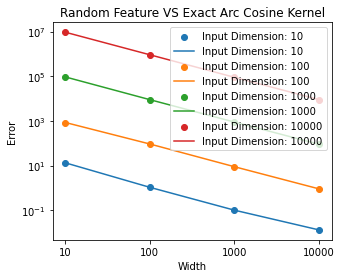

In [3]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(1, 1, 1)
ax.set_title("Random Feature VS Exact Arc Cosine Kernel")
ax.set_xticks(np.arange(0, len(width_list), 1))
ax.set_xticklabels(width_list)
ax.set_xlabel("Width")
ax.set_ylabel("Error")
ax.set_yscale('log')
              
for i, dimension in enumerate(dimension_list):
    ax.scatter(np.arange(0, len(dimension_list), 1), residue_results[i,:].reshape(-1,), label="Input Dimension: "+str(dimension))
    ax.plot(residue_results[i,:].reshape(-1,), label="Input Dimension: "+str(dimension))
ax.legend()
plt.show()

# Arc-Cosine Kernel on (partial) MNIST

Load data

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

Select two numbers. Randomly select $3$ and $8$ (with no reason, just randomly)

In [3]:
train_index = np.logical_or(y_train==3, y_train==8)
test_index = np.logical_or(y_test==3, y_test==8)
x_train = x_train[train_index]
y_train = y_train[train_index]
x_test = x_test[test_index]
y_test = y_test[test_index]

Reshape

In [4]:
x_train = x_train.reshape((x_train.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))
y_train = y_train.reshape((y_train.shape[0],))
y_test = y_test.reshape((y_test.shape[0],))

Test Kernels

In [7]:
ACOS_K = Arc_Cosine_Kernel(order=1)
clf = SVC(kernel=ACOS_K.kernel_function)
clf.fit(x_train, y_train)
clf.score(x_test, y_test, sample_weight=None)

0.9944556451612904

In [20]:
width_list = [1e4 for _ in range(2)]
Random_Relu_Net = Random_Relu_Network(width_list=width_list)
clf = SVC(kernel=Random_Relu_Net.kernel_function)
clf.fit(x_train, y_train)
clf.score(x_test, y_test, sample_weight=None)

0.9889112903225806

In [21]:
Single_Layer_Relu_Net = Single_Layer_Relu_Network(width=1e4)
clf = SVC(kernel=Single_Layer_Relu_Net.kernel_function)
clf.fit(x_train, y_train)
clf.score(x_test, y_test, sample_weight=None)

0.9929435483870968

Test SGD

In [24]:
clf = SGDClassifier(max_iter=1000, tol=1e-3)
clf.fit(x_train, y_train)
clf.score(x_test, y_test, sample_weight=None)

0.9596774193548387

In [38]:
Single_Layer_Relu_Net = Single_Layer_Relu_Network(width=1e2)
x_train_map = Single_Layer_Relu_Net.output(x_train)
x_test_map = Single_Layer_Relu_Net.output(x_test)
clf = SGDClassifier(max_iter=1000, tol=1e-3)
clf.fit(x_train_map, y_train)
clf.score(x_test_map, y_test, sample_weight=None)

0.9465725806451613

In [39]:
width_list = [1e2 for _ in range(2)]
Random_Relu_Net = Random_Relu_Network(width_list=width_list)
x_train_map = Random_Relu_Net.output(x_train)
x_test_map = Random_Relu_Net.output(x_test)
clf = SGDClassifier(max_iter=1000, tol=1e-3)
clf.fit(x_train_map, y_train)
clf.score(x_test_map, y_test, sample_weight=None)

0.9349798387096774